## Netflix Recommender System

**1. Problem Definition**

Netflix is a web streaming service that allows audience to select from a wide range of TV series, movies, documentaries, etc. One of the most important aspects of online services or ecommerce websites is to be able to provide customized content recommendations to the audience, based on a user's likes and likes of other similar users. This business problem can be addressed by creating a recommender system using Movie rating data that contains information about the ratings given to different movies or TV shows by each Customer ID. A system such as this can help users conviniently find items of their interest and also help the web service to identify most relevant movies for each Customer ID. This can help online platforms to offer discounts and offers to the right users. A recommender system can help Netflix increase business revenue through increased consumption. 

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from rich.jupyter import print
sns.set_style('white')
get_ipython().run_line_magic('matplotlib', 'inline')

**2. Load Data**

We load the Netflix movie rating data stored in four separate text files using Pandas and combine them in a single data frame

In [2]:
#Load data into Pandas Dataframe
data1 = pd.read_csv("C:\\Users\\pragy\\Desktop\\Netflix Recommender System\\combined_data_1.txt", header=None, names = ['CustomerID', 'Rating'], usecols=[0,1])
data2 = pd.read_csv("C:\\Users\\pragy\\Desktop\\Netflix Recommender System\\combined_data_2.txt", header=None, names = ['CustomerID', 'Rating'], usecols=[0,1])
data3 = pd.read_csv("C:\\Users\\pragy\\Desktop\\Netflix Recommender System\\combined_data_3.txt", header=None, names = ['CustomerID', 'Rating'], usecols=[0,1])
data4 = pd.read_csv("C:\\Users\\pragy\\Desktop\\Netflix Recommender System\\combined_data_4.txt", header=None, names = ['CustomerID', 'Rating'], usecols=[0,1])

#Change 'Rating' type to float
data1['Rating'] = data1['Rating'].astype(float)
data2['Rating'] = data2['Rating'].astype(float)
data3['Rating'] = data3['Rating'].astype(float)
data4['Rating'] = data4['Rating'].astype(float)

In [3]:
#Check the shape of the data frames
print('[bold magenta]Shape of Combined data 1:',data1.shape)
print('[bold magenta]Shape of Combined data 2:',data2.shape)
print('[bold magenta]Shape of Combined data 3:',data3.shape)
print('[bold magenta]Shape of Combined data 4:',data4.shape)

In [4]:
#Combining all data frames 
MovieRating_data = data1
MovieRating_data = data1.append(data2)
MovieRating_data = MovieRating_data.append(data3)
MovieRating_data = MovieRating_data.append(data4)

#set index
MovieRating_data.index = np.arange(0,len(MovieRating_data))

In [13]:
print('[bold magenta]Shape of the Movie Rating data is:',MovieRating_data.shape)

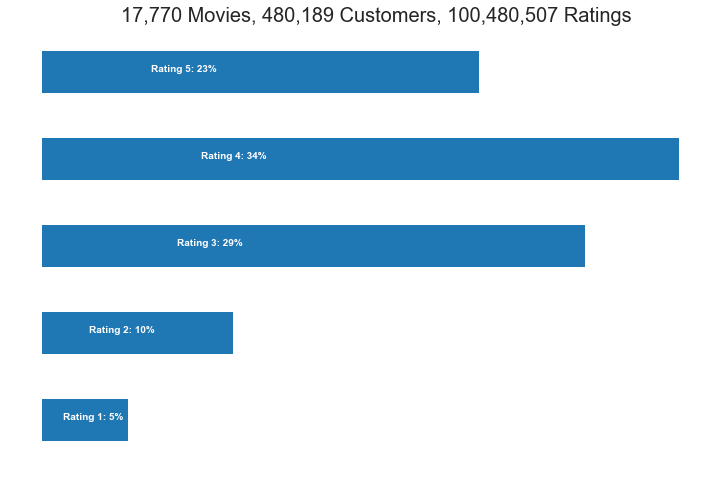

In [5]:
#Visualize Spread of Movie Ratings 
p = MovieRating_data.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = MovieRating_data.isnull().sum()[1]

# get customer count
cust_count = MovieRating_data['CustomerID'].nunique() - movie_count

# get rating count
rating_count = MovieRating_data['CustomerID'].count() - movie_count
    
ax = p.plot(kind = 'barh', legend = False, figsize = (12,8))
plt.title('{:,} Movies, {:,} Customers, {:,} Ratings'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i,p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

The above graph suggests that users who like a movie are more likely to rate them than users who don't like them. About 86% of the customers have given a rating of 3 or higher to movies in the Netflix data base. 

In [10]:
#Descriptive Statistics
Number_of_ratings = pd.DataFrame(MovieRating_data.groupby('CustomerID')['Rating'].count())
print(Number_of_ratings.describe())

The descriptive statistics of the **number of ratings** by **Customer ID** show that it has a right skewed distribution as the mean is greater than the median. This implies that the Netflix data contains majority of the information where number of ratings per customer ID is relatively low. On the other hand, the maximum number of ratings given by a user is 17653.   

**3. Data Cleaning**

In [7]:
#Reset Index for nan values in Movie rating Data
df_nan = pd.DataFrame(pd.isnull(MovieRating_data.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

#Add Movie ID by creating Numpy array
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1
# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(MovieRating_data) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('[bold magenta]Movie numpy: {}'.format(movie_np))
print('[bold magenta]Length: {}'.format(len(movie_np)))

In [11]:
#Taking non-null values
MovieRating_data = MovieRating_data[pd.notnull(MovieRating_data['Rating'])]

#Converting Movie ID and Customer ID to 'int'
MovieRating_data['Movie_Id'] = movie_np.astype(int)
MovieRating_data['CustomerID'] = MovieRating_data['CustomerID'].astype(int)
print('[bold magenta]-Netflix Movie Ratings-[/]')
print(MovieRating_data.iloc[::5000000, :])

C:\Users\pragy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\pragy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We will now filter the data based on the number of ratings per Customer ID as the data contains **100480507** records. We have selected 2000 as the threshold value above which we will consider the number of ratings per user by trial and error method.

In [14]:
#Filtering data for customers who are relatively inactive in rating movies to reduce the data size for faster computation
MovieRating_data = MovieRating_data.groupby('CustomerID').filter(lambda x:x['Rating'].count() >= 2000).reset_index(drop = True)

In [19]:
print('[bold magenta]Shape of the new Movie Rating data is:',MovieRating_data.shape)

In [20]:
#Created a function to change the Movie Id and Customer ID to an iterative value from 0 which further helps in creating a matrix
def manipul(df,col):
    df = df.sort_values(col).reset_index(drop = True)
    c = df.columns.get_loc(col)
    x = 1
    p = 1
    for i in df.itertuples():
        if x == 1:
            if i[c+1] == p:
                x = x + 1
                val = i[c+1]
                continue
            else:
                val = i[c+1]
                df.at[x - 1, col] = p
                #i[c+1] = p
                x = x + 1       

        else:
            if val == i[c+1]:
                df.at[x - 1, col] = p
            else:
                val = i[c+1]
                df.at[x - 1, col] = p + 1
                p = p + 1
            x = x + 1
    return df            

In [21]:
#Applying manipul function to Customer ID and Movie Id
MovieRating_data = manipul(MovieRating_data, "CustomerID")
MovieRating_data = manipul(MovieRating_data, "Movie_Id")

MovieRating_data = MovieRating_data[['CustomerID','Movie_Id','Rating']]

In [22]:
#Load Movie Titles csv file
movie_titles = pd.read_csv("C:\\Users\\pragy\\Desktop\\Netflix Recommender System\\movie_titles.csv", encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
movie_titles.set_index('Movie_Id', inplace = True)

In [23]:
#Merge Movie ratings with movie title data on Movie_Id
FinalNetflix_data = pd.merge(MovieRating_data,movie_titles,on='Movie_Id')
FinalNetflix_data.head()

,CustomerID,Movie_Id,Rating,Year,Name
0,871,1,4.0,2003.0,Dinosaur Planet
1,96,1,3.0,2003.0,Dinosaur Planet
2,829,1,4.0,2003.0,Dinosaur Planet
3,248,1,1.0,2003.0,Dinosaur Planet
4,539,1,3.0,2003.0,Dinosaur Planet


**4. Data Exploration**

## EDA

Now we will explore the data and try to understand the distribution of movie ratings.

In [24]:
#Get the top five highest rated movies on average
FinalNetflix_data.groupby('Name')['Rating'].mean().sort_values(ascending=False).head(5)

Name
Lord of the Rings: The Return of the King: Extended Edition: Bonus Material    5.000000
The Jack Bull                                                                  4.645720
The Lord of the Rings: The Fellowship of the Ring: Extended Edition            4.644737
Lord of the Rings: The Two Towers: Extended Edition                            4.633727
Raiders of the Lost Ark                                                        4.542024
Name: Rating, dtype: float64

The table above shows the average of Top five highest rated movies in the Netflix data. **Lord of the Rings** is the highest rated movie with a rating of 5.

In [25]:
#Get the top five movies with highest number of user ratings
FinalNetflix_data.groupby('Name')['Rating'].count().sort_values(ascending=False).head()

Name
The Godfather               2029
Psycho                      1831
The Manchurian Candidate    1645
Bad Boys                    1622
Gone in 60 Seconds          1578
Name: Rating, dtype: int64

The table above shows that **'The Godfather'** received the highest number of ratings from users.

In [26]:
#Get mean number of ratings of movies
Ratings = pd.DataFrame(FinalNetflix_data.groupby('Name')['Rating'].mean())
Ratings.head()

,Rating
Name,
'Allo 'Allo!: Series 1,3.752212
'Allo 'Allo!: Series 2,2.391304
'Allo 'Allo!: Series 3,2.767500
'N Sync: 'N the Mix,1.881356
'N Sync: Live at Madison Square Garden,2.031250


In [27]:
#Get the number of ratings for each movie
Ratings['num of ratings'] = pd.DataFrame(FinalNetflix_data.groupby('Name')['Rating'].count())
Ratings.head()

,Rating,num of ratings
Name,,
'Allo 'Allo!: Series 1,3.752212,113
'Allo 'Allo!: Series 2,2.391304,23
'Allo 'Allo!: Series 3,2.767500,400
'N Sync: 'N the Mix,1.881356,59
'N Sync: Live at Madison Square Garden,2.031250,96


The table above shows the average ratings and the number of ratings given to movies.

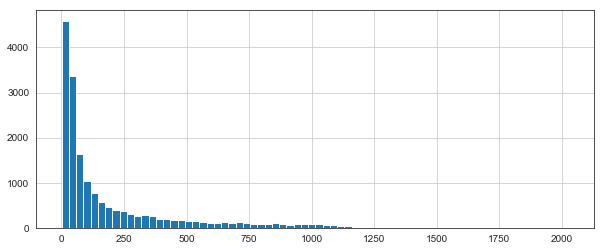

In [28]:
#Check the distribution of number of ratings
plt.figure(figsize=(10,4))
Ratings['num of ratings'].hist(bins=70)

The distribution of number of ratings is skewed to the right which implies that the data contains more movies that have been rated by a high number of users. On the other hand, the data on movies is relatively less which have been rated by less number of users.

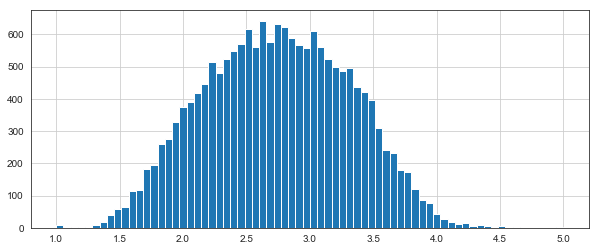

In [29]:
#Check the distribution of ratings
plt.figure(figsize=(10,4))
Ratings['Rating'].hist(bins=70)

The distribution of ratings approximates a Normal distribution. It can be seen that most of the movies are rated between 2.5 and 3 approx.

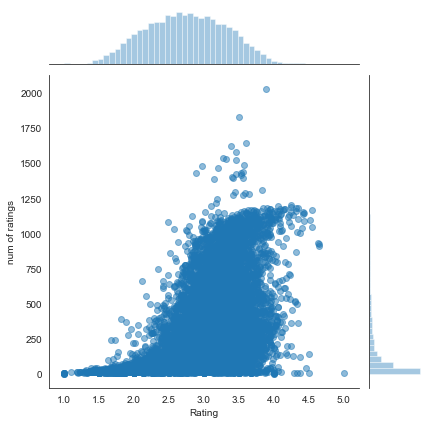

In [30]:
#Check the relationship between number of ratings and ratings
sns.jointplot(x='Rating',y='num of ratings',data=Ratings,alpha=0.5)

The joinplot above shows the relationship between **'number of ratings'** and **'Rating'**. There is a somewhat positive association between these two variables i.e. movies with a high rating have received more number of ratings than the ones that have been given a rating ranging between 1 and 2.5.

Now let's have a look at the unique number of users and unique number of movies.

In [31]:
n_users = FinalNetflix_data.CustomerID.nunique() #Get the unique number of users
n_items = FinalNetflix_data.Movie_Id.nunique() #Get the unique number of movies

print('[bold magenta]Num. of Users:[/]'+ str(n_users))
print('[bold magenta]Num of Movies:[/]'+str(n_items))

## Collaborative Filtering

**5. Modeling**

Collaborative Filtering method has been used to create our Movie Recommender system. The algorithm has the ability to do feature learning on its own, which means that it can start to learn for itself what features to use. 

CF can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. 

We being by using Memory-Based CF on our Netflix data with 1214 users and 17768 movies.

In [32]:
#import train test split
from sklearn.model_selection import train_test_split

**a. Memory-Based Collaborative Filtering**

Instead of dividing the data into X_train,X_test,y_train and y_test, we will segment the data into train and test sets.

In [33]:
#Segment data into train and test sets
train_data, test_data = train_test_split(FinalNetflix_data, test_size=0.25)

Memory-Based Collaborative Filtering approaches can be divided into two main sections: **user-item filtering** and **item-item filtering**. 

A *user-item filtering* will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. 

In contrast, *item-item filtering* will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations. 

* *Item-Item Collaborative Filtering*: “Users who liked this item also liked …”
* *User-Item Collaborative Filtering*: “Users who are similar to you also liked …”

In both cases, you create a user-item matrix which built from the entire dataset.

Since we have split the data into testing and training we will need to create two ``[1214 x 17768]`` matrices (all users by all movies). 

The training matrix contains 75% of the ratings and the testing matrix contains 25% of the ratings.  

After you have built the user-item matrix you calculate the similarity and create a similarity matrix. 

The similarity values between items in *Item-Item Collaborative Filtering* are measured by observing all the users who have rated both items. 

For *User-Item Collaborative Filtering* the similarity values between users are measured by observing all the items that are rated by both users.

In [34]:
#Convert the Netflix Movie Ratings data frame to train and test matrices
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

A distance metric commonly used in recommender systems is *cosine similarity*, where the ratings are seen as vectors in ``n``-dimensional space and the similarity is calculated based on the angle between these vectors.

We will use the pairwise distances function from sklearn to calculate the cosine similarity. Note, the output will range from 0 to 1 since the ratings are all positive.

In [35]:
#Use pairwise function from sklearn to calculate cosine similarity for predicting ratings
from sklearn.metrics.pairwise import pairwise_distances

user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [36]:
#Create a function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [37]:
item_prediction = predict(train_data_matrix, item_similarity, type='item') #Get item prediction
user_prediction = predict(train_data_matrix, user_similarity, type='user') #Get user prediction

**6. Evaluation**

There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted ratings is *Root Mean Squared Error (RMSE)*.

Since you only want to consider predicted ratings that are in the test dataset, you filter out all other elements in the prediction matrix with `prediction[ground_truth.nonzero()]`. 

In [38]:
#Import library for RMSE evaluation metric
from sklearn.metrics import mean_squared_error
from math import sqrt

#Create a function to return RMSE value
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [39]:
#Get the RMSE value for User-based and Item-based
print('[bold magenta]User-based CF RMSE:[/] ' + str(rmse(user_prediction, test_data_matrix)))
print('[bold magenta]Item-based CF RMSE:[/] ' + str(rmse(item_prediction, test_data_matrix)))

User-based approach gives a lower RMSE value of 2.39 compared to Item-based with RMSE of 3.07. Thus, a user-based approach will generate better rating predictions.

Memory-based algorithms are easy to implement and produce reasonable prediction quality. 
The drawback of memory-based CF is that it doesn't scale to real-world scenarios and doesn't address the well-known cold-start problem, that is when new user or new item enters the system. Model-based CF methods are scalable and can deal with higher sparsity level than memory-based models, but also suffer when new users or items that don't have any ratings enter the system.

*Source:* (http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/)

**b. Model-Based C-F**

Model-based Collaborative Filtering is based on **matrix factorization (MF)** which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF. The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. 
When we have a very sparse matrix, with a lot of dimensions, by doing matrix factorization we can restructure the user-item matrix into low-rank structure, and represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. We fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

Let's calculate the sparsity level of our Netflix data

In [40]:
#Calculate the Sparsity level of the matrix
sparsity=round(1.0-len(FinalNetflix_data)/float(n_users*n_items),3)
print('[bold magenta]The sparsity level of Netflix data is[/] ' +  str(sparsity*100) + '%')

## SVD

A well-known matrix factorization method is **Singular value decomposition (SVD)**. Collaborative Filtering can be formulated by approximating a matrix `X` by using singular value decomposition.

The equation for SVD can be described as follows:

Given `m x n` matrix `X`:
* *`U`* is an *`(m x r)`* orthogonal matrix
* *`S`* is an *`(r x r)`* diagonal matrix with non-negative real numbers on the diagonal
* *V^T* is an *`(r x n)`* orthogonal matrix

Elements on the diagnoal in `S` are known as *singular values of `X`*. 


Matrix *`X`* can be factorized to *`U`*, *`S`* and *`V`*. The *`U`* matrix represents the feature vectors corresponding to the users in the hidden feature space and the *`V`* matrix represents the feature vectors corresponding to the items in the hidden feature space.

We can make a prediction by taking dot product of *`U`*, *`S`* and *`V^T`*.

In [41]:
#Calculate SVD
u, s, vt = svds(train_data_matrix, k = 20) #Decomposing the matrix using k = 20 singular values in the diagonal matrix
s_diag_matrix=np.diag(s) #Extract a diagonal matrix
X_pred = np.dot(np.dot(u, s_diag_matrix), vt) #predict by taking the dot product of U, S and V matrices
print('[bold magenta]User-based CF MSE:[/] ' + str(rmse(X_pred, test_data_matrix)))

Carelessly addressing only the relatively few known entries is highly prone to overfitting. SVD can be very slow and computationally expensive. 